In [ ]:
import sys
from pathlib import Path
from typing import *

import requests
import pandas as pd
from tqdm import tqdm

sys.path.insert(0, '/home/tas/Workspace/python/pysimple/src')
sys.path.insert(0, '/home/tas/Workspace/python/pyturdus/src')
from pysimple.io import to_tsv, from_tsv
from pyturdus.bird import Bird

In [18]:
XC_API = 'http://www.xeno-canto.org/api/2'
DATA_DIR = Path('/mnt/storage/tas/data/xeno-canto')

### 1 Download birds records

In [19]:
RECORDS_API = XC_API + '/recordings?query=nr:0-10000000&page=%d'

def get_records(page: int) -> Dict:
    return requests.get(RECORDS_API % page).json()

In [27]:
records_path = DATA_DIR / 'records' / 'records.tsv'
try:
    records = from_tsv(filepath=records_path)
except FileNotFoundError:
    records = []
    pages = int(get_records(page=1)['numPages'])
    for page in tqdm(range(1, pages+1)):
        page_records_path = DATA_DIR / 'records' / 'pages' / f'{page}.tsv'
        try:
            page_records = from_tsv(filepath=page_records_path)
        except FileNotFoundError:
            try:
                page_records = pd.DataFrame(get_records(page)['recordings'])
            except Exception as err:
                print(err)
                page_records = pd.DataFrame()
            else:
                to_tsv(filepath=page_records_path, data=page_records)
        finally:
            records.append(page_records)
    records = pd.concat(records)
    to_tsv(filepath=records_path, data=records)
    records = from_tsv(filepath=records_path)

100%|██████████| 1045/1045 [10:05<00:00,  1.73it/s]


In [25]:
len(records)

483372

### 2 Download birds calls

In [ ]:
RECORDS_DIR = CWD / 'data' / 'records'
CALL_URL = 'https://www.xeno-canto.org/%d/download'

def get_call(rid: int):
    return requests.get(CALL_URL % rid).content

def load_rids(ntop: int=10) -> List[int]:
    """Load record ids for most popular species"""
    rr = from_tsv(RECORDS_DIR / 'all.tsv')
    rr = rr[rr['q'].eq('A')]
    gen = rr['gen'].value_counts().index[:ntop]
    rr = rr[rr['gen'].isin(gen)]
    return rr['id'].astype(int).tolist()

In [ ]:
CALLS_DIR = CWD / 'data' / 'calls'
!mkdir -p {CALLS_DIR}

for rid in tqdm(load_rids(ntop=32)):
    try:
        c = get_call(rid=rid)
    except Exception as err:
        print(err)
        continue
    else:
        with open(CALLS_DIR / f'{rid}.mp3', 'wb') as f:
            f.write(c)

### 3 Into birds

In [2]:
RECORDS_DIR = CWD / 'data' / 'records'
CALLS_DIR = CWD / 'data' / 'calls'

rr = from_tsv(RECORDS_DIR / 'all.tsv').set_index('id')

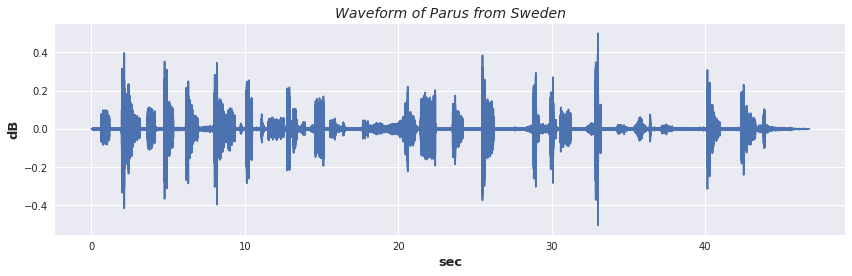

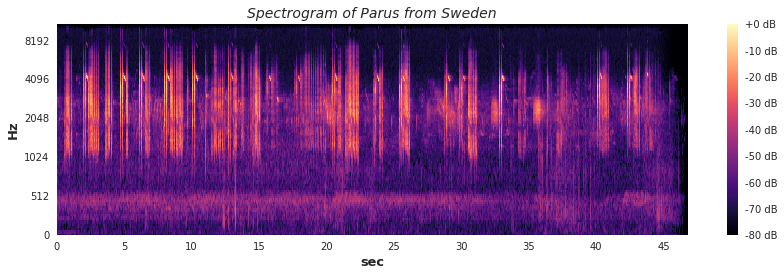

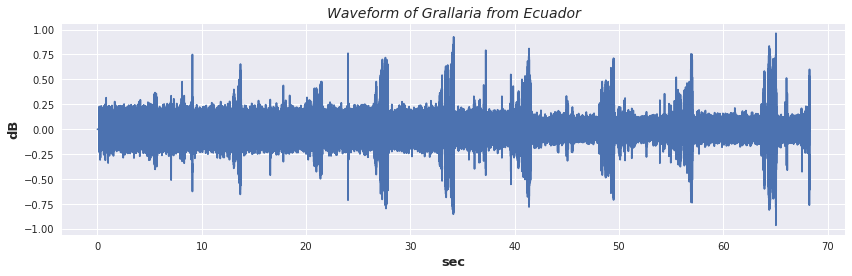

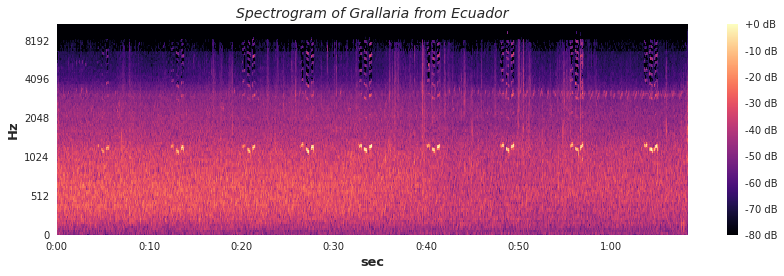

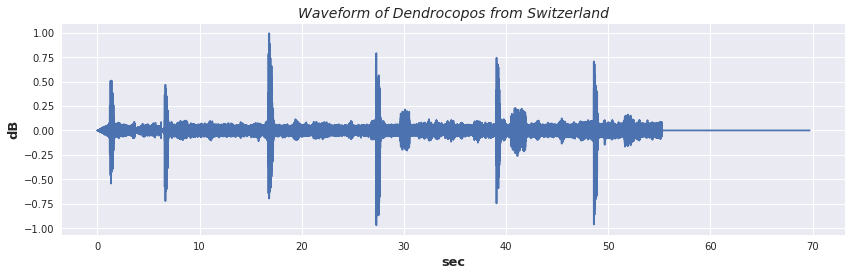

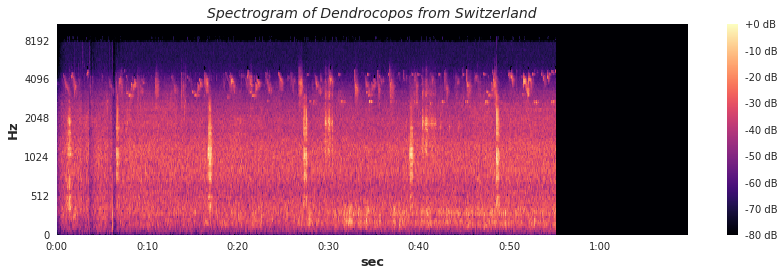

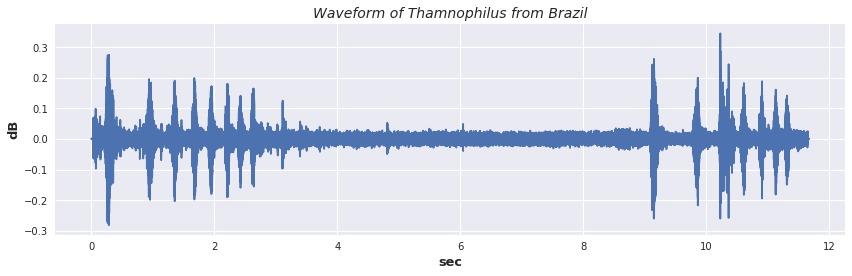

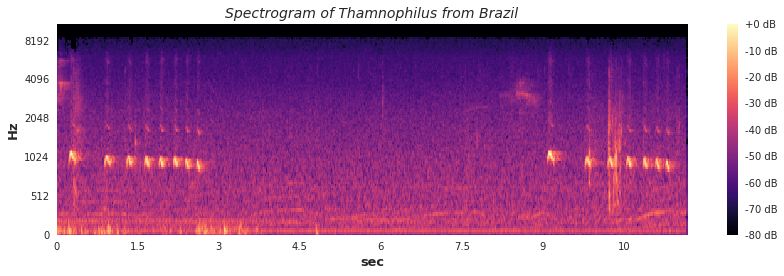

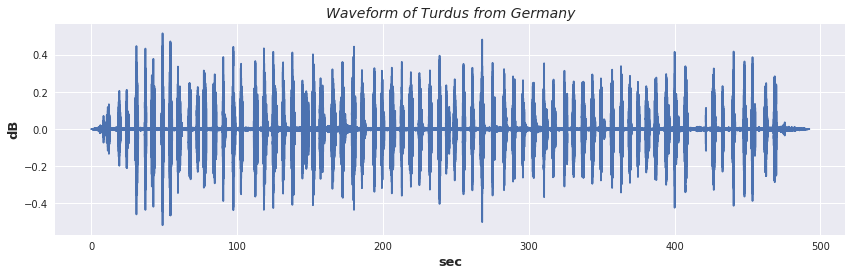

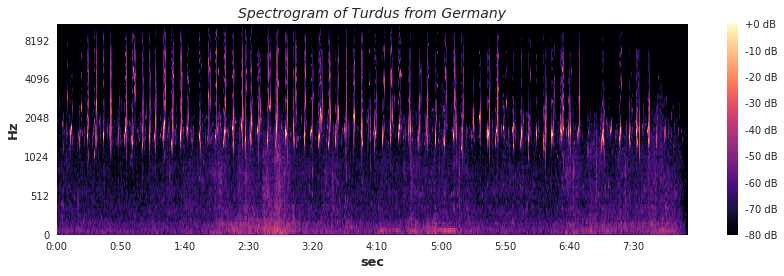

In [3]:
for i, callpath in enumerate(CALLS_DIR.iterdir()):
    if i == 5: break
    rid = callpath.stem
    r = rr.loc[rid]
    b = Bird(id=rid, name=r['gen'], country=r['cnt'], quality=r['q'])
    b.load_call(callpath=callpath)
    b.load_call(callpath, sr=None)
    b.plot_waveform()
    b.plot_spectrogram()